# Wczytujemy dane

In [1]:
import os
import matplotlib.pyplot as plt
import mne

%matplotlib inline

In [3]:
data_dir = (r'C:\Users\student\Desktop\dane')
os.chdir(data_dir)
files = os.listdir()
fname = 'sternberg_diam_015_AK-epo.fif'
has_file = fname in files
print('{} w wybranym folderze.'.format(['pliku nie ma', 'plik znajduje się'][has_file]))

plik znajduje się w wybranym folderze.


In [4]:
epochs = mne.read_epochs(fname, preload=True)
# epochs.set_eeg_reference()

Reading sternberg_diam_015_AK-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms (None)
        0 CTF compensation matrices available
281 matching events found
281 matching events found
0 projection items activated


Jak już opowiadaliśmy na zajęciach w pliku przed 0.5 sekundy sporo się dzieje, idealnie byłoby liczyć widmo od 0.5 sekundy:

Applying baseline correction (mode: mean)


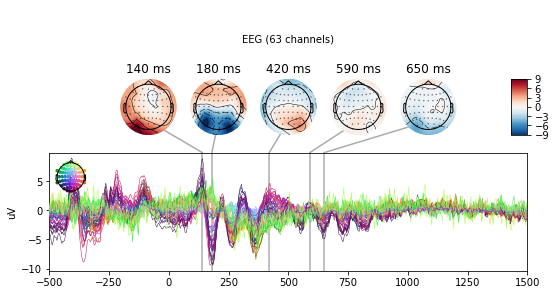

In [5]:
erp = epochs.average().apply_baseline()
erp.plot_joint(times=[0.14, 0.18, 0.42, 0.59, 0.65]);

Epoki mają już zawartą informację o tym, która przynależy do którego warunku:

In [6]:
epochs['l3']

<EpochsFIF  |  n_events : 46 (all good), tmin : -0.5 (s), tmax : 1.5 (s), baseline : (-0.20000000298023224, 0.0), ~11.2 MB, data loaded>

`l3` to *load 3* czyli obciążenie pamięci krótkotrwałej trzema cyframi. Wszystkie warunki możemy obejrzeć w atrybucie `event_id`:

In [7]:
epochs.event_id

{'l2': 102, 'l3': 103, 'l4': 104, 'l5': 105, 'l6': 106, 'l7': 107}

mamy warunki od *load 2* aż do *load 7*

Wybierzemy na razie dwie elektrody: 'Fz' oraz 'Pz'. Porównamy z nich średnie widmo, a następnie specyficzne dla warunków.

In [8]:
Fz = epochs.ch_names.index('Fz')
Pz = epochs.ch_names.index('Pz')
ch_idx = [Fz, Pz]

In [9]:
from mne.time_frequency import psd_welch
psd, freq = psd_welch(epochs, picks=ch_idx, tmin=0.5,
                      n_fft=epochs.info['sfreq'], fmax=25.)

Effective window size : 1.000 (s)


In [10]:
psd.shape

(281, 2, 26)

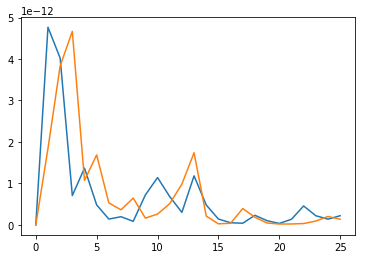

In [11]:
epoka = 23
plt.plot(freq, psd[epoka].T)

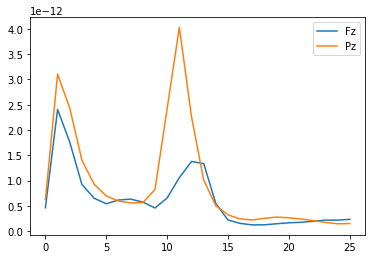

In [12]:
# uśredniamy epoki
psd_avg = psd.mean(axis=0)
plt.plot(freq, psd_avg.T)
plt.legend(['Fz', 'Pz'], loc='upper right')

Oscylacje alfa są (dużo) silniejsze ciemieniowo, natomiast theta jest wyraźniejsza czołowo.
Porównajmy teraz warunki l2 i l4:

In [13]:
psd_l2, freq = psd_welch(epochs['l2'], picks=ch_idx, tmin=0.5,
                         n_fft=epochs.info['sfreq'], fmax=25.)
psd_l4, freq = psd_welch(epochs['l4'], picks=ch_idx, tmin=0.5,
                         n_fft=epochs.info['sfreq'], fmax=25.)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)


In [14]:
psd_l2_avg = psd_l2.mean(axis=0)
psd_l4_avg = psd_l4.mean(axis=0)

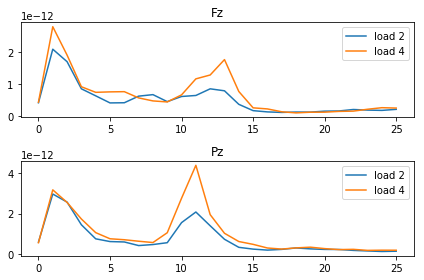

In [15]:
# teraz chemy dwa wykresy
fig, ax = plt.subplots(nrows=2)

# dla elektrody Fz
ax[0].plot(freq, psd_l2_avg[0])
ax[0].plot(freq, psd_l4_avg[0])
ax[0].legend(['load 2', 'load 4'])
ax[0].set_title('Fz')

# dla elektrody Pz
ax[1].plot(freq, psd_l2_avg[1])
ax[1].plot(freq, psd_l4_avg[1])
ax[1].legend(['load 2', 'load 4'])
ax[1].set_title('Pz')

plt.tight_layout() # układa nam wykresy aby np. nie nakładały się za bardzo tytuły (rozszerza odstęp)

Wygląda na to, że różnice w alfie w elektrodzie czołowej są w wyższych częstotliwościach niż dla elektrod potylicznych.
Od tego momentu startują zajęcia: 
1. chcemy zdefiniować sobie dwa pasma częstotliwościowe:
  * 9 - 11 Hz (tu widać efekt dla elektrod potylicznych)
  * 11 - 14 Hz (tu widać efekt dla elektrod czołowych)  
  aby sobie ułatwić ten krok - stoworzymy funkcję
2. uśrednimy w tych pasmach widmo dla nieuśrednionego po epokach psd
3. porównamy warunki (l2 vs l4) za pomocą testu t
4. Przykład użycia `SpectrumPlot`

In [20]:
def hej_dodaj(kaczka, ryba):
    suma = kaczka + ryba
    return suma

In [21]:
hej_dodaj(5, 3) == 8

True

In [25]:
def hej_policz(a, b):
    return 2 * a + b / 3 + 7

In [24]:
hej_policz(0, 0)

7.0

In [27]:
import numpy as np

In [28]:
f = np.array([2., 2.5, 3., 3.5, 6., 8., 11.])

In [29]:
f

array([  2. ,   2.5,   3. ,   3.5,   6. ,   8. ,  11. ])

In [35]:
abs_diff = np.abs(freq - lo)
np.argmin(abs_diff)

3

In [36]:
abs_diff = np.abs(f - 6.3)
np.argmin(abs_diff)

4

In [47]:
def znajdź_zakres(freq, lo, hi):
    abs_diff_lo = np.abs(freq - lo)
    lo_idx = np.argmin(abs_diff_lo)
    
    abs_diff_hi = np.abs(freq - hi)
    hi_idx = np.argmin(abs_diff_hi)
    
    return lo_idx, hi_idx + 1

In [41]:
f

array([  2. ,   2.5,   3. ,   3.5,   6. ,   8. ,  11. ])

In [48]:
l, h = znajdź_zakres(f, 3., 6.)

In [49]:
f[l:h]

array([ 3. ,  3.5,  6. ])

In [39]:
nie_rób_nic(23, 'hauhauhau')

(23, 'hauhauhau')

## Czas-częstość

In [16]:
import numpy as np
from mne.time_frequency import tfr_morlet

In [32]:
freq = np.arange(3, 13, 0.25)
n_cycles = freq / 3.

tfr = tfr_morlet(epochs, freq, n_cycles, use_fft=True, return_itc=False)

In [22]:
%matplotlib

Using matplotlib backend: Qt5Agg


Applying baseline correction (mode: percent)


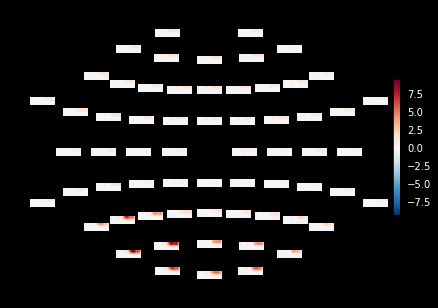

In [29]:
tfr.plot_topo(baseline=(-0.4, -0.1), mode='percent')

Applying baseline correction (mode: mean)


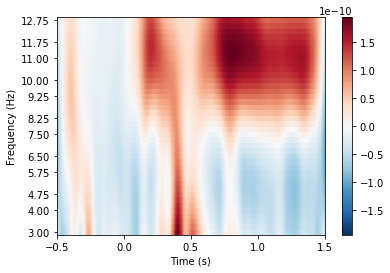

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [30]:
tfr.plot([Fz], baseline=(-0.4, -0.1))

Teraz porównujemy load dla wybranej elektrody (np Oz) - tfr plot.
Test t - jeżeli starczy sił.